In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import PurePath
from utils import Identity, compute_identity_stats, read_json, generate_esm2_embeddings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"])

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/data_leakage/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

In [3]:
if not os.path.exists(".cache/figs"):
    os.makedirs(".cache/figs")

# Filter dataset

In [4]:
data = read_json("../data/build/dataset.json")
dataset = [(sample["ID"], sample["Sequence"]) for sample in data if MIN_SEQ_LEN <= len(sample["Sequence"]) <= MAX_SEQ_LEN]
output_path = ".cache/mmseqs/dataset.fasta"
if not os.path.exists(PurePath(output_path).parent):
    os.makedirs(PurePath(output_path).parent)
with open(output_path, 'w') as f:
    for id_, seq in dataset:
        f.write(f">{id_}\n{seq}\n")
print(f"Filtered dataset saved to {output_path}")

Filtered dataset saved to .cache/mmseqs/dataset.fasta


# Cluster sequences using MMseqs2

In [5]:
# If you installed mmseqs2 with bioconda, you might not be able to run this cell. In such case, please run the script from a terminal where you activated the bioconda environment.
!./mmseqs/cluster_mmseqs.sh

zsh:1: no such file or directory: ./mmseqs/cluster_mmseqs.sh


# Load clusters

In [6]:
clusters = pd.read_csv(".cache/mmseqs/clusters.tsv", sep="\t", header=None)
clusters.columns = ["reference_sequence_id", "sequence_id"]

# Split clusters into two sets

In [7]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['reference_sequence_id'].unique()
    print("Found", len(cluster_ids), "clusters.")
    n_test = int(len(cluster_ids) * test_ratio) # Number of clusters to be used for testing
    test_clusters = set(cluster_ids[:n_test])
    train_clusters = set(cluster_ids[n_test:])
    train_ids = clusters[clusters['reference_sequence_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['reference_sequence_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)

Found 8431 clusters.


# Assert independence between training and test sets

In [8]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|████████████████████████████████████|  3312/3312 [00:11<00:00, 183.05it/s] 


In [9]:
test2train_id = identities.max(axis=1)

Max identity: 1.0
Mean identity: 0.7267175215623541
Median identity: 0.7692307692307693
Quantiles:
- 0.01 quantile: 0.34285714285714286
- 0.05 quantile: 0.41025641025641024
- 0.10 quantile: 0.46153846153846156
- 0.25 quantile: 0.6
- 0.50 quantile: 0.7692307692307693
- 0.75 quantile: 0.875
- 0.90 quantile: 0.9230769230769231
- 0.95 quantile: 0.9285714285714286
- 0.99 quantile: 1.0
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
5115


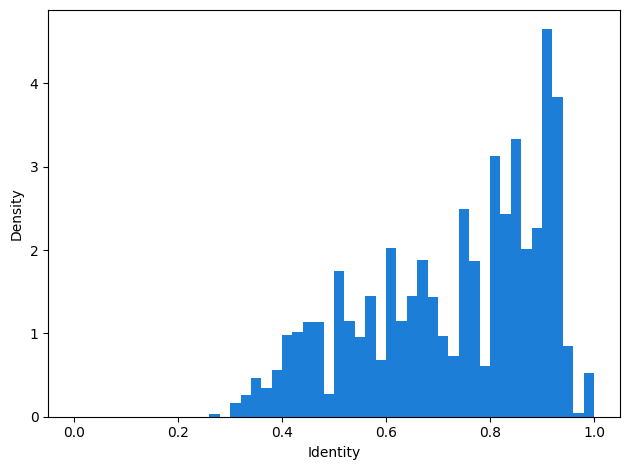

In [10]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
# plt.title("Highest identity between each test sequence and all train sequences")
plt.tight_layout()
plt.savefig(".cache/figs/mmseqs_split.svg")

In [11]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 15710


In [12]:
# Get train/test sequences
train_seqs = [sample["Sequence"] for sample in data if sample["ID"] in train_ids]
test_seqs = [sample["Sequence"] for sample in data if sample["ID"] in test_ids]
# Get train/test e coli MIC
train_mic = [sample["Targets"].get("Escherichia coli", (None,))[0] for sample in data if sample["ID"] in train_ids]
test_mic = [sample["Targets"].get("Escherichia coli", (None,))[0] for sample in data if sample["ID"] in test_ids]
train_mask = [mic is not None for mic in train_mic]
test_mask = [mic is not None for mic in test_mic]
train_seqs = [seq for seq, mask in zip(train_seqs, train_mask) if mask]
test_seqs = [seq for seq, mask in zip(test_seqs, test_mask) if mask]
train_mic = np.array([mic for mic in train_mic if mic is not None])
test_mic = np.array([mic for mic in test_mic if mic is not None])
print("Train mean: {}, std: {}".format(np.mean(np.log10(train_mic)), np.std(np.log10(train_mic))))
print("Test mean: {}, std: {}".format(np.mean(np.log10(test_mic)), np.std(np.log10(test_mic))))

# Generate train/test embeddings
train_X = generate_esm2_embeddings(train_seqs, batch_size=128, device="mps")
test_X = generate_esm2_embeddings(test_seqs, batch_size=128, device="mps")
# Train a linear regression model
model = LinearRegression().fit(train_X, np.log10(train_mic))
# Evaluate the model
test_pred = model.predict(test_X)
pcc = pearsonr(test_pred, np.log10(test_mic)).statistic
pcc

Train mean: 1.3219640369708971, std: 1.0251718798468796
Test mean: 1.4326948464321585, std: 1.016066766218503


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|█████████████████████████████████████████|  90/90 [16:01<00:00, 10.57s/it] 


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 100%|█████████████████████████████████████████|  18/18 [07:01<00:00, 15.63s/it] 


np.float64(0.5484295496878582)